# Générer des réalisations d'une variable aléatoire par inversion de la fonction de répartition

## Introduction

Dans cette page, nous présentons comment générer des réalisations d'une variable aléatoire par inversion de la fonction de répartition. La méthode est fondée sur le principe suivant. Soit $X$ une variable aléatoire de fonction de répartition $F$. Si $U$ est une variable aléatoire uniforme entre 0 et 1, alors la variable $F^{-1}(U)$ a la même distribution que $X$. La méthode consiste à générer une observation $U$ de la variable aléatoire $U$. Alors $x = F^{-1}(u)$ est une observation de la variable $X$. 

Cette méthode de génération n'est presque pas utilisée en pratique, pour des raisons à la fois de performance, de qualité des nombres aléatoires générés et de précision numérique lorsqu'on réalise les calculs avec des nombres à virgule flottante. Toutefois, elle a un intérêt pédagogique, car elle permet d'observer la distribution des nombres générés.

[Pour voir ce Jupyter Notebook, nous conseillons NBViewer.](https://nbviewer.org/github/mbaudin47/otsupgalilee-eleve/blob/master/1-Intro-OT/Generer-par-inversion.ipynb)

## Application à la loi de Weibull

Soient $\alpha>0$ et $\beta>0$ deux paramètres réels : $\alpha$ est un paramètre de forme et $\beta$ est un paramètre d'échelle.
La fonction de répartition de la loi de Weibull est :
$$
F(x) = 1 - \exp\left( - \left(\frac{x}{\beta}\right)^\alpha\right),
$$
pour $x\geq 0$.

Dans d'autres contextes, les paramètres sont notés $k=\alpha$ et $\lambda=\beta$.

L'inverse de la fonction de répartition est :
$$
F^{-1}(p) = \beta \left(-\log(1 - p)\right)^{\frac{1}{\alpha}}
$$
pour $p \in [0, 1]$.
Cette fonction est souvent nommée fonction $quantile$, car elle calcule le quantile $F^{-1}(p)$ en fonction d'une probabilité $p$.

## Perte de précision si p est proche de 1

En pratique, il s'avère que, si la probabilité $p$ est très proche de 1, alors $1 - p$ est très proche de zéro. Cela peut entraîner une forte perte de précision lors de l'évaluation de la soustraction $1 - p$ avec des nombres à virgule flottante, car 1 et $p$ ont beaucoup de chiffres communs lorsque $p$ est très proche de 1. Le phénomène associé à un tel calcul est la *perte de chiffres significatifs par cancellation*, une difficulté tout à fait récurrente dans ce contexte. 

Pour la fonction de répartition, on peut utiliser la fonction $\textrm{expm1}$, définie par :
$$
\textrm{expm1}(x) = \exp(x)-1,
$$
pour tout $x\in\mathbb{R}$.
La fonction de répartition est :
$$
F(x) = -\textrm{expm1} \left(\left(-\frac{x}{\beta}\right)^\alpha\right),
$$
pour $x\geq 0$.

Pour évaluer l'inverse de la fonction de répartition, c'est-à-dire la fonction quantile, on peut utiliser la fonction $\textrm{log1p}$, définie par :
$$
\textrm{log1p}(x) = \log(1+x)
$$
si $x>-1$.

La fonction quantile est :
$$
F^{-1}(p) = \beta \left(-\textrm{log1p}(-p)\right)^{\frac{1}{\alpha}}
$$
pour $p \in [0, 1]$.

Dans la suite de ce texte, on n'évoquera plus cette difficulté.

## Génération par inversion : histogramme et densité

In [1]:
import openturns as ot
import numpy as np

Dans OpenTURNS, la loi uniforme par défaut est entre -1 et 1. C'est pourquoi on spécifie explicitement les bornes.

In [2]:
U = ot.Uniform(0.0, 1.0)

On génère un échantillon de taille n=1000 de la loi uniforme entre 0 et 1.

In [3]:
n = 1000
sample = U.getSample(n)
p = sample.asPoint()

On définit les paramètres de la loi de Weibull.

In [4]:
beta = 5.0
alpha = 3.0


On convertit l'échantillon en `array` numpy, puis on applique la fonction quantile de la loi de Weibull (en utilisant la valeur par défaut du paramètre de position $\gamma=0$).

In [5]:
W = ot.WeibullMin(beta, alpha)
x = W.computeQuantile(p)

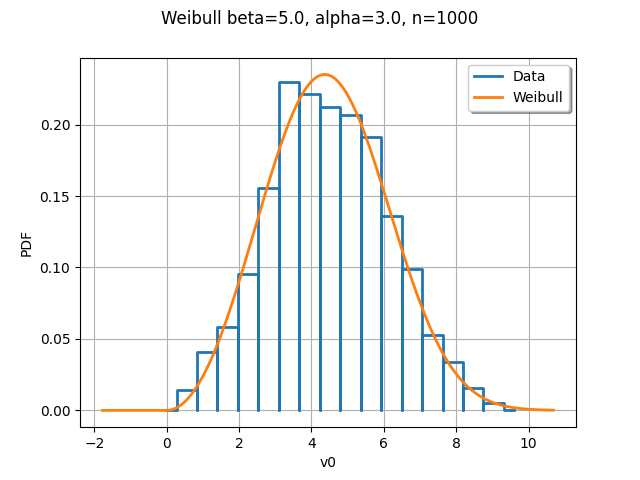

In [6]:
histo = ot.HistogramFactory().build(x).drawPDF()
histo.setTitle(f"Weibull beta={beta}, alpha={alpha}, n={n}")
histo.setLegends(["Data"])
wpdf = W.drawPDF()
wpdf.setLegends(["Weibull"])
histo.add(wpdf)
histo

## Observation des quantiles

In [7]:
n = 50
sample = U.getSample(n)
p = sample.asPoint()

In [8]:
x = W.computeQuantile(p)

On trie les observations $X$ par ordre croissant. Nous souhaitons ordonner les observations correspondantes de $U$. Pour cela, nous stockons les couples **(x, p)** dans un échantillon bi-dimensionnel.

In [9]:
data = ot.Sample(n, 2)
data[:, 0] = x
data[:, 1] = sample
data.setDescription(["x", "p"])

La méthode `sortAccordingToAComponent()` trie un échantillon selon une composante. Ici, nous trions les couples **(x, p)** par ordre croissant de $X$.

In [10]:
data = ot.Sample(data.sort())
data[0:5, :]

,x,p
0,0.9941088,0.007828637
1,1.34142,0.01912483
2,1.668725,0.03649194
3,1.806528,0.04607047
4,1.842134,0.0487797


In [11]:
x = data[:, 0]
p = data[:, 1]

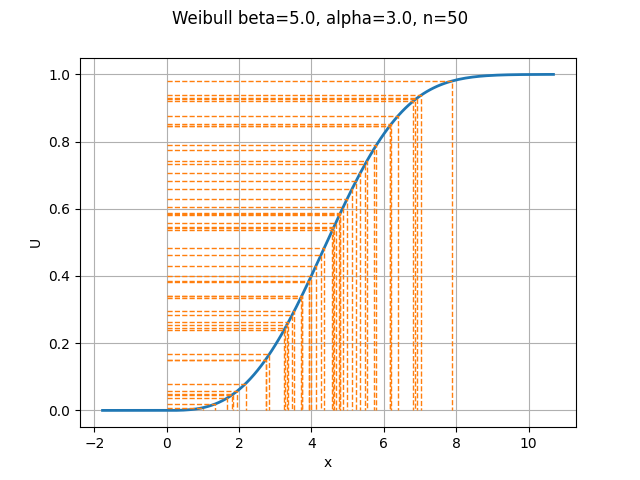

In [12]:
graph = ot.Graph(f"Weibull beta={beta}, alpha={alpha}, n={n}", "x", "U", True)
palette = ot.DrawableImplementation.BuildDefaultPalette(2)
# Ajoute la fonction de répartition
curve = W.drawCDF()
curve.setColors([palette[0]])
graph.add(curve)
# Ajoute les traits
for i in range(n):
    # Trait horizontal, puis vertical
    curve = ot.Curve([0.0, x[i, 0], x[i, 0]], [p[i, 0], p[i, 0], 0.0])
    curve.setColor(palette[1])
    curve.setLineStyle("dashed")
    graph.add(curve)
graph

On observe que la distribution des traits verticaux (sur l'axe $X$) est celle de la loi de Weibull. La distribution des traits horizontaux (sur l'axe $U$) suit la loi uniforme.